In [1]:
'''
Experiment with models and methods
'''

'\nExperiment with models and methods\n'

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdkit.Chem.PandasTools as rdk
import os
import re
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer


In [3]:
# Now we can import the dataset

dataset_path = "/Users/gaurishlakhanpal/Downloads/assay_central_tb.sdf"

dataset = rdk.LoadSDF(dataset_path)

In [4]:
# We visualise and understand the dataset

print(dataset.columns)

print(dataset.head(1))

print(len(dataset))

Index(['SMILES', 'InChI', 'single-class-label', 'ID', 'ROMol'], dtype='object')
                                              SMILES  \
0  Nc1ncnc2c1c(-c1c[nH]nn1)cn2[C@@H]1O[C@H](CO)[C...   

                                               InChI single-class-label ID  \
0  InChI=1S/C13H15N7O4/c14-11-8-5(6-1-17-19-18-6)...                  0      

                                               ROMol  
0  <img data-content="rdkit/molecule" src="data:i...  
18738


In [5]:
# Smiles = smiles encoding
# InChI = some other encoding format
# ID = tb positive or not (0 = no, 1 = yes)

In [6]:
# Let's one hot encode the smiles data so we can start to analyse it

# in trying to encode we will have to make an array of arrays
# each array will encode one character for that character 
# the remaining space will be padded 

In [7]:
# Let's get all the unique characters first

unique_characters = []
unique_vals = []

tokenizer = BasicSmilesTokenizer()

for compound in dataset['SMILES']:
    val = tokenizer.tokenize(compound)
    for char in val:
        if(not(char in unique_characters)):
            unique_characters.append(char)

In [8]:
unique_characters

['N',
 'c',
 '1',
 'n',
 '2',
 '(',
 '-',
 '[nH]',
 ')',
 '[C@@H]',
 'O',
 '[C@H]',
 'C',
 's',
 '=',
 'F',
 '[N+]',
 '[O-]',
 'o',
 '3',
 '4',
 '5',
 '6',
 '7',
 '/',
 'Cl',
 '\\',
 'S',
 '#',
 '[n+]',
 '[S@]',
 '[C@]',
 '[C@@]',
 'I',
 '[Se]',
 '[se]',
 '[N-]',
 '[S+]',
 'P',
 '8',
 '[Na]',
 '[Si]',
 '[C-]',
 '[B-]',
 'B',
 'Br']

In [9]:
len(unique_characters)

46

In [10]:
# Alright let's look at the length of the smiles characters 

smiles_length = []

for compounds in dataset['SMILES']:
    smiles_length.append(len(compounds))

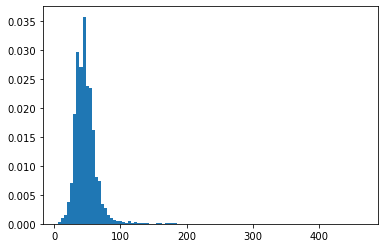

In [11]:
# Let's plot the lengths

plt.hist(smiles_length, density = True, bins = 100)
plt.show()

In [12]:
# median and quartiles

q1 = np.percentile(smiles_length, [25])
q2 = np.percentile(smiles_length, [50])
q3 = np.percentile(smiles_length, [75])
q4 = np.percentile(smiles_length, [99])

iqr = q3 - q1

upper_outlier_range = q3 + iqr * 1.5 
lower_outlier_range = q1 - iqr * 1.5 

print(q1)
print(q2)
print(q3)
print(q4)
print(iqr)
print(upper_outlier_range)
print(lower_outlier_range)

[37.]
[45.]
[54.]
[113.]
[17.]
[79.5]
[11.5]


In [13]:
# We'll use values that are longer than our bottom outlier and shorter than the top 1% of values

smiles = []
smile_classes = []

counter = 0
for compound in dataset['SMILES']:
    if(len(compound) >= lower_outlier_range and len(compound) <= q4):
        smiles.append(compound)
        smile_classes.append(dataset['single-class-label'][counter])
    counter += 1

In [14]:
# Visualize
smiles[0:5]

['Nc1ncnc2c1c(-c1c[nH]nn1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ncnc2c1c(-c1nccs1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ncnc2c1c(-c1c[nH]cn1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ncnc2c1c(-c1ncc[nH]1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'O=C(O)c1nc(O)nc(O)c1F']

In [15]:
smiles[4]

'O=C(O)c1nc(O)nc(O)c1F'

In [16]:
tokenizer.tokenize(smiles[4]) 

['O',
 '=',
 'C',
 '(',
 'O',
 ')',
 'c',
 '1',
 'n',
 'c',
 '(',
 'O',
 ')',
 'n',
 'c',
 '(',
 'O',
 ')',
 'c',
 '1',
 'F']

In [17]:
# We can now encode this reduced dataset 

upper_outlier_range = 79 # 79.5

num_unique_characters = 46 # 37

encoding = np.zeros(shape = (upper_outlier_range, num_unique_characters))

In [18]:
# let's define a function to one hot encode our data

def one_hot(smile_encoding, unique_chars = unique_characters):
    smile_encoding = tokenizer.tokenize(smile_encoding) 
    
    matrix = np.zeros(shape = (113, num_unique_characters))
    
    for i in range(len(smile_encoding)):
        matrix[i, unique_chars.index(smile_encoding[i])] = 1
        
    return matrix

In [19]:
one_hot(smiles[2])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
# Define a function to created a weighted vector 

def weighted(smile_encoding, unique_chars = unique_characters):
    
    smile_encoding = tokenizer.tokenize(smile_encoding) 
    
    matrix = np.zeros(shape = (1, 46))
    for i in range(len(smile_encoding)):
        matrix[0, unique_chars.index(smile_encoding[i])] += 1
        
    return (matrix)

In [21]:
# One hot encoding vectors
"""enc_smiles = []

for x in smiles:
    enc_smiles.append(one_hot(x))"""

'enc_smiles = []\n\nfor x in smiles:\n    enc_smiles.append(one_hot(x))'

In [22]:
# Creating the prediction set

for x in range(len(smile_classes)):
    smile_classes[x] = int(smile_classes[x])

In [23]:
# Weighted vectors
# Our input data

enc_smiles = []

for x in smiles:
    enc_smiles.append(weighted(x))



In [24]:
enc_smiles

[array([[1., 8., 6., 5., 2., 3., 1., 1., 3., 2., 4., 2., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1., 9., 6., 4., 2., 3., 1., 0., 3., 2., 4., 2., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1., 9., 6., 4., 2., 3., 1., 1., 3., 2., 4., 2., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1., 9., 6., 4., 2., 3., 1., 1., 3., 2., 4., 2., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 4., 2., 2., 0., 3., 0., 0., 3., 0., 4., 0., 1., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [25]:
# standard scale
enc_smiles = np.array(enc_smiles)

nsamples, nx, ny = enc_smiles.shape
enc_smiles = enc_smiles.reshape((nsamples,nx*ny))


In [26]:
enc_smiles

array([[1., 8., 6., ..., 0., 0., 0.],
       [1., 9., 6., ..., 0., 0., 0.],
       [1., 9., 6., ..., 0., 0., 0.],
       ...,
       [0., 6., 2., ..., 0., 0., 1.],
       [1., 6., 2., ..., 0., 0., 1.],
       [1., 6., 2., ..., 0., 0., 1.]])

In [27]:
# Standard scaling values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
enc_smiles = scaler.fit_transform(enc_smiles)

In [28]:
# We can now work with these encodings...

In [29]:
# Let's split into test and train
# 42 is the best random state

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(enc_smiles, smile_classes, test_size = .25)

In [30]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#sm = SMOTE(sampling_strategy=1)
#x_train, y_train = sm.fit_resample(x_train, y_train)

In [31]:
# SVM 

from sklearn import svm

clf = svm.SVC(kernel = "rbf", class_weight = {1:1, 0:4})
clf.fit(x_train, y_train)

SVC(class_weight={0: 4, 1: 1})

In [32]:
y_pred = clf.predict(x_test)

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)

array([[4479,  143],
       [   1,    7]])

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)
print(accuracy_score(y_pred = y_pred, y_true = y_test))
print(precision_score(y_pred = y_pred, y_true = y_test))

0.9688984881209504
0.875


In [35]:
counter = 0
for x in range(len(y_pred)):
    if(y_test[x] == 1 and y_pred[x] == 1):
        counter += 1
print(counter)

7


In [36]:
counter = 0
counter2 = 0
for x in y_train:
    counter2 += 1
    if(x == 1):
        counter += 1
        
print(counter)
print(counter2)

434
13889


In [37]:
# Random forest 

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight = {1:1, 0:4})
model.fit(x_train, y_train)


y_pred = model.predict(x_test)

In [38]:
accuracy_score(y_pred, y_test)

0.9697624190064795

In [39]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

[[4440   40]
 [ 100   50]]
0.9697624190064795
0.5555555555555556


In [40]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight = {1:1, 0:4})
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

[[4480  150]
 [   0    0]]
0.9676025917926566
0.0


/Users/gaurishlakhanpal/opt/anaconda3/envs/tb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)

print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

[[  72    3]
 [4408  147]]
0.04730021598272138
0.0322722283205269


In [42]:
# Reformat for neural network
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [43]:
# Let's try neural network...

In [44]:
import tensorflow as tf

# 1; 6 6 1 size = 32, epochs = 100 accuracy = 99.4
# 2; 6 6 1 size = 32, epochs = 50
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64,activation="relu"))
ann.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
ann.add(tf.keras.layers.Dense(units=32,activation="relu"))
ann.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
ann.add(tf.keras.layers.Dense(units=16,activation="relu"))
ann.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
history = ann.fit(x_train, y_train, batch_size=64, epochs = 20, validation_data = (x_test, y_test))

2022-02-21 13:25:08.927270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
218/218 [==============================] - 1s 2ms/step - loss: 0.2097 - accuracy: 0.9556 - val_loss: 0.1333 - val_accuracy: 0.9676
Epoch 2/20
218/218 [==============================] - 0s 2ms/step - loss: 0.1317 - accuracy: 0.9687 - val_loss: 0.1253 - val_accuracy: 0.9676
Epoch 3/20
218/218 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.9688 - val_loss: 0.1233 - val_accuracy: 0.9678
Epoch 4/20
218/218 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9691 - val_loss: 0.1214 - val_accuracy: 0.9678
Epoch 5/20
218/218 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.9692 - val_loss: 0.1189 - val_accuracy: 0.9685
Epoch 6/20
218/218 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9698 - val_loss: 0.1217 - val_accuracy: 0.9665
Epoch 7/20
218/218 [==============================] - 0s 1ms/step - loss: 0.1023 - accuracy: 0.9699 - val_loss: 0.1186 - val_accuracy: 0.9659
Epoch 

In [45]:
y_pred = ann.predict(x_test)

In [46]:
# The neural network predicts a very small value like .000000000001 instead of 0, so we make those 0
for x in range(len(y_pred)):
    if(y_pred[x] < .1):
        y_pred[x] = 0
    else:
        y_pred[x] = 1

In [47]:
from sklearn.metrics import accuracy_score

#ypred2 = clf.predict(x_test)
print("Neural Network: " + str(accuracy_score(y_pred, y_test)))
#print("SVM: " + str(accuracy_score(ypred2, y_test)))

Neural Network: 0.9306695464362851


In [48]:
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

[[4220  260]
 [  61   89]]
0.9306695464362851
0.25501432664756446


In [49]:
counter = 0
for x in y_test:
    if(x == 1):
        counter += 1
        
print(counter)

150


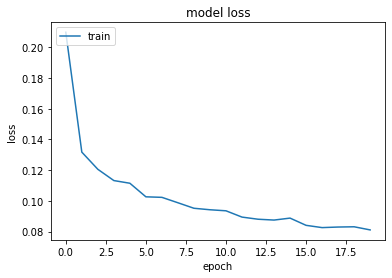

In [50]:
import keras
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()